# KNN (temp)

In [67]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [69]:

df = pd.read_csv("data.csv")
df = df.drop(columns=["id", "Unnamed: 32"])
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"].map({"M": 1, "B": 0}).astype(int)

X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X, y, test_size=0.2, random_state=314, stratify=y)
print("Train size:", X_trainlog.shape, "Test size:", X_testlog.shape)


Train size: (455, 30) Test size: (114, 30)


In [71]:
kf = KFold(n_splits=5, shuffle=True, random_state=314)

feature_range = [5, 10, 15]
k_range = range(1, 16)

best_score = 0
best_k = None
best_f = None
best_feature_mask = None

for num_features in feature_range:
    for k_val in k_range:
        fold_scores = []
        
        for train_idx, val_idx in kf.split(X_trainlog):
            X_train = X_trainlog.iloc[train_idx]
            X_val = X_trainlog.iloc[val_idx]
            y_train = y_trainlog.iloc[train_idx]
            y_val = y_trainlog.iloc[val_idx]
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            selector = SelectKBest(score_func=f_classif, k=num_features)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_val_selected = selector.transform(X_val_scaled)
            
            knn = KNeighborsClassifier(n_neighbors=k_val)
            knn.fit(X_train_selected, y_train)
            score = knn.score(X_val_selected, y_val)
            fold_scores.append(score)
        
        avg_score = np.mean(fold_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k_val
            best_f = num_features
            best_feature_mask = selector.get_support()

print(f"Best cross-validation score: {best_score:.4f}")
print(f"Best number of neighbors: {best_k}")
print(f"Best number of features: {best_f}")

Best cross-validation score: 0.9429
Best number of neighbors: 5
Best number of features: 10


In [42]:
from sklearn.metrics import accuracy_score

y_train_pred = knn_final.predict(X_train_selected)
y_test_pred = knn_final.predict(X_test_selected)

train_acc = accuracy_score(y_trainlog, y_train_pred)
test_acc = accuracy_score(y_testlog, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9604
Test Accuracy: 0.9649


In [44]:
selected_features = X.columns[selector.get_support()]
print("Selected Features:")
for feat in selected_features:
    print("-", feat)


Selected Features:
- radius_mean
- perimeter_mean
- area_mean
- concavity_mean
- concave points_mean
- radius_worst
- perimeter_worst
- area_worst
- concavity_worst
- concave points_worst


In [56]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on your existing train set
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_trainlog, y_trainlog)


LogisticRegression(max_iter=10000)

Test Accuracy: 0.9473684210526315
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



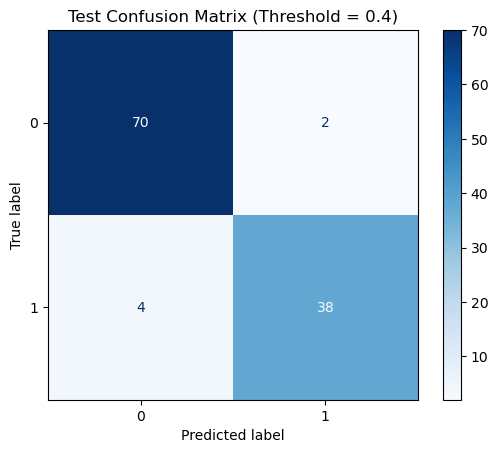

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

threshold = 0.4

# --- Train Set ---
y_probs_train = log_reg.predict_proba(X_trainlog)[:, 1]
y_train_adjusted = (y_probs_train >= threshold).astype(int)

# print("Train Accuracy:", accuracy_score(y_trainlog, y_train_adjusted))
# print("Train Classification Report:\n", classification_report(y_trainlog, y_train_adjusted))
# ConfusionMatrixDisplay.from_predictions(y_trainlog, y_train_adjusted, cmap=plt.cm.Blues)
# plt.title("Train Confusion Matrix (Threshold = 0.4)")
# plt.show()

# --- Test Set ---
y_probs_test = log_reg.predict_proba(X_testlog)[:, 1]
y_test_adjusted = (y_probs_test >= threshold).astype(int)

print("Test Accuracy:", accuracy_score(y_testlog, y_test_adjusted))
print("Test Classification Report:\n", classification_report(y_testlog, y_test_adjusted))
ConfusionMatrixDisplay.from_predictions(y_testlog, y_test_adjusted, cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix (Threshold = 0.4)")
plt.show()



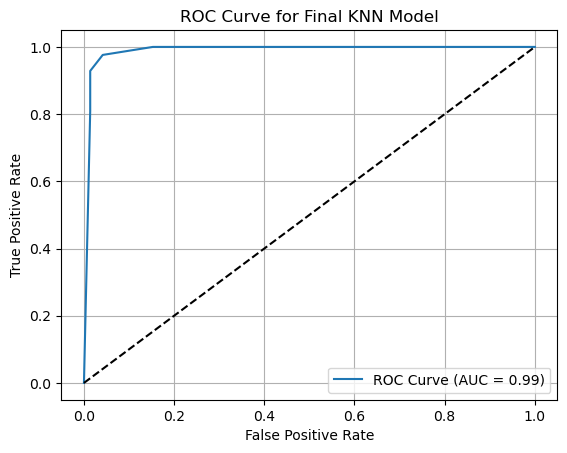

In [74]:
from sklearn.metrics import roc_curve, auc

y_prob = knn_final.predict_proba(X_test_selected)[:, 1]

fpr, tpr, _ = roc_curve(y_testlog, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Final KNN Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()